Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


465/465 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0147 - val_loss: 0.0015
Epoch 2/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/ste

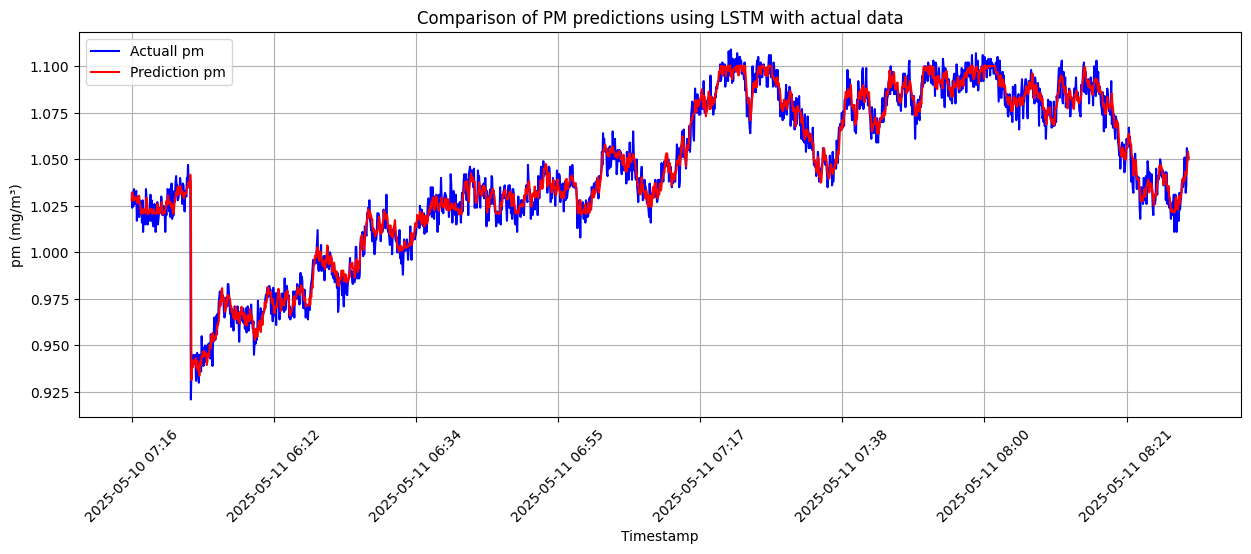


Layer 0 - lstm_3
  Bobot ke-0 shape: (4, 256)
  Bobot ke-1 shape: (64, 256)
  Bobot ke-2 shape: (256,)

Layer 1 - dense_3
  Bobot ke-0 shape: (64, 1)
  Bobot ke-1 shape: (1,)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.dates as mdates


# --- Load data ---
df = pd.read_excel("dataseth.xlsx")
df.dropna(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

# --- Fitur dan target ---
features = ['temperature', 'humidity', 'distance', 'speed']
target = 'pm'   # target sekarang pm

# Ambil hanya data 7 hari
data_7hari = df[df['date'] <= pd.to_datetime("2025-05-11").date()]

X = data_7hari[features].values
y = data_7hari[target].values.reshape(-1, 1)

# --- Normalisasi ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# --- Sliding window ---
sequence_length = 24
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# --- Split train/test 80:20 ---
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

# --- Bangun model LSTM ---
model = Sequential()
model.add(LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- Training ---
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=16, verbose=1)

# --- Evaluasi ---
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Balik ke skala asli
y_train_true = scaler_y.inverse_transform(y_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred)
y_test_true = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

X_train_last = X_train[:, -1, :]   # shape (n_train, n_features)
X_test_last = X_test[:, -1, :]     # shape (n_test, n_features)

# --- Kembalikan ke skala asli ---
X_train_true = scaler_X.inverse_transform(X_train_last)
X_test_true = scaler_X.inverse_transform(X_test_last)

y_train_true = scaler_y.inverse_transform(y_train)
y_test_true = scaler_y.inverse_transform(y_test)

# --- Ambil timestamp sesuai split ---
timestamp_seq = data_7hari['timestamp'].values[sequence_length:]
timestamp_train = timestamp_seq[:len(X_train_true)]
timestamp_test = timestamp_seq[len(X_train_true):]

train_df = pd.DataFrame(X_train_true, columns=features)
train_df[target] = y_train_true
train_df["timestamp"] = timestamp_train

# --- Buat DataFrame Test ---
test_df = pd.DataFrame(X_test_true, columns=features)
test_df[target] = y_test_true
test_df["timestamp"] = timestamp_test

# --- Simpan ke Excel ---
with pd.ExcelWriter("train_test_split.xlsx") as writer:
    train_df.to_excel(writer, sheet_name="Train", index=False)
    test_df.to_excel(writer, sheet_name="Test", index=False)

# Hitung metrik
print("\nEvaluasi Training Data:")
print(f"R² Score : {r2_score(y_train_true, y_train_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_train_true, y_train_pred):.4f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_train_true, y_train_pred)):.4f}")

print("\nEvaluasi Test Data:")
print(f"R² Score : {r2_score(y_test_true, y_test_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_test_true, y_test_pred):.4f}")
print(f"MSE     : {np.sqrt(mean_squared_error(y_test_true, y_test_pred)):.4f}")

# --- Ambil timestamp yang sejajar dengan y_seq ---
timestamps_seq = data_7hari['timestamp'].iloc[sequence_length:].reset_index(drop=True)

# Split timestamp sama dengan y_seq
timestamps_train = timestamps_seq[:split_index]
timestamps_test = timestamps_seq[split_index:]

plt.figure(figsize=(15,5))

# Buat index numerik sesuai panjang data test
indices = np.arange(len(timestamps_test))

# Plot pakai index
plt.plot(indices, y_test_true, label="Actuall pm", color='blue')
plt.plot(indices, y_test_pred, label="Prediction pm", color='red')

# xticks per 250 data, label pakai timestamp asli
step = 250
plt.xticks(
    ticks=indices[::step],
    labels=timestamps_test.iloc[::step].dt.strftime('%Y-%m-%d %H:%M'),
    rotation=45
)

plt.xlabel("Timestamp")
plt.ylabel("pm (mg/m³)")
plt.title("Comparison of PM predictions using LSTM with actual data")
plt.legend()
plt.grid(True)
plt.show()

# --- Ambil bobot (weight & bias) dari model ---
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"\nLayer {i} - {layer.name}")
    for j, w in enumerate(weights):
        print(f"  Bobot ke-{j} shape: {w.shape}")
# Simpan semua weight & bias ke Excel
with pd.ExcelWriter("model_weights_bias_pm.xlsx") as writer:
    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        for j, w in enumerate(weights):
            df = pd.DataFrame(w)  # ubah array jadi tabel
            sheet_name = f"{layer.name}_w{j}"
            df.to_excel(writer, sheet_name=sheet_name, index=False)



Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


465/465 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0117 - val_loss: 0.0015
Epoch 2/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 3/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 5/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 10/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 11/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 12/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/st

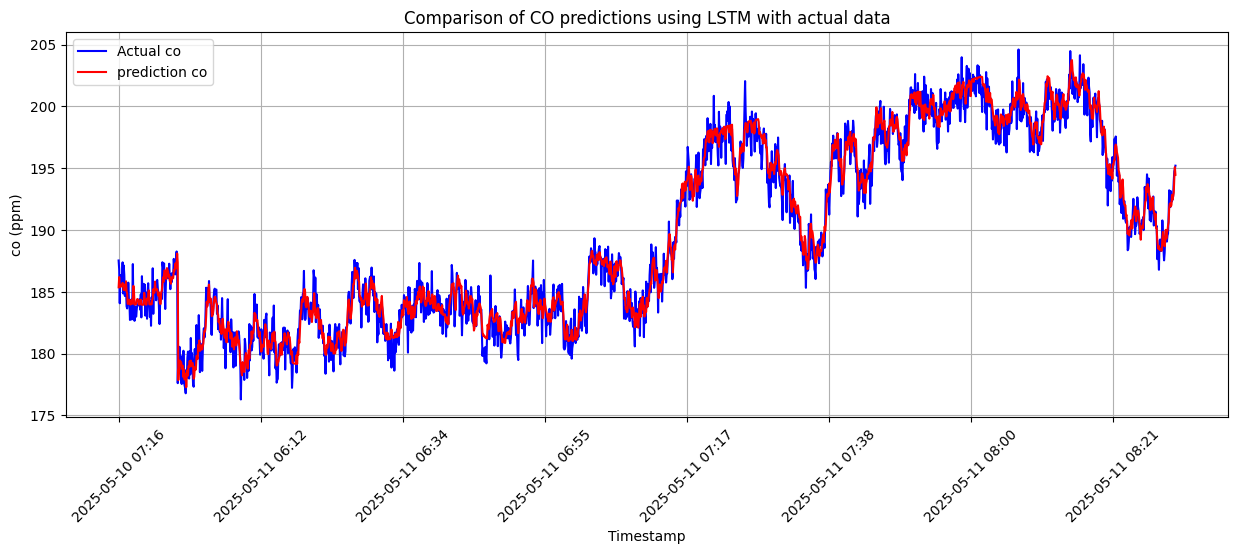


Layer 0 - lstm_4
  Bobot ke-0 shape: (4, 256)
  Bobot ke-1 shape: (64, 256)
  Bobot ke-2 shape: (256,)

Layer 1 - dense_4
  Bobot ke-0 shape: (64, 1)
  Bobot ke-1 shape: (1,)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load data ---
df = pd.read_excel("dataseth.xlsx")
df.dropna(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

# --- Fitur dan target ---
features = ['temperature', 'humidity', 'distance', 'speed']
target = 'co'   # target sekarang CO

# Ambil hanya data 7 hari
data_7hari = df[df['date'] <= pd.to_datetime("2025-05-11").date()]

X = data_7hari[features].values
y = data_7hari[target].values.reshape(-1, 1)

# --- Normalisasi ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# --- Sliding window ---
sequence_length = 24  # 24 jam
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# --- Split train/test 80:20 ---
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

# --- Bangun model LSTM ---
model = Sequential()
model.add(LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- Training ---
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=16, verbose=1)

# --- Evaluasi ---
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Balik ke skala asli
y_train_true = scaler_y.inverse_transform(y_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred)
y_test_true = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

# Hitung metrik
print("\nEvaluasi Training Data:")
print(f"R² Score : {r2_score(y_train_true, y_train_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_train_true, y_train_pred):.4f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_train_true, y_train_pred)):.4f}")

print("\nEvaluasi Test Data:")
print(f"R² Score : {r2_score(y_test_true, y_test_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_test_true, y_test_pred):.4f}")
print(f"MSE     : {np.sqrt(mean_squared_error(y_test_true, y_test_pred)):.4f}")

# --- Ambil timestamp yang sejajar dengan y_seq ---
timestamps_seq = data_7hari['timestamp'].iloc[sequence_length:].reset_index(drop=True)

# Split timestamp sama dengan y_seq
timestamps_train = timestamps_seq[:split_index]
timestamps_test = timestamps_seq[split_index:]

plt.figure(figsize=(15,5))

# Buat index numerik sesuai panjang data test
indices = np.arange(len(timestamps_test))

# Plot pakai index
plt.plot(indices, y_test_true, label="Actual co", color='blue')
plt.plot(indices, y_test_pred, label="prediction co", color='red')

# xticks per 250 data, label pakai timestamp asli
step = 250
plt.xticks(
    ticks=indices[::step],
    labels=timestamps_test.iloc[::step].dt.strftime('%Y-%m-%d %H:%M'),
    rotation=45
)

plt.xlabel("Timestamp")
plt.ylabel("co (ppm)")
plt.title("Comparison of CO predictions using LSTM with actual data")
plt.legend()
plt.grid(True)
plt.show()

# --- Ambil bobot (weight & bias) dari model ---
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"\nLayer {i} - {layer.name}")
    for j, w in enumerate(weights):
        print(f"  Bobot ke-{j} shape: {w.shape}")
# Simpan semua weight & bias ke Excel
with pd.ExcelWriter("model_weights_bias_co.xlsx") as writer:
    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        for j, w in enumerate(weights):
            df = pd.DataFrame(w)  # ubah array jadi tabel
            sheet_name = f"{layer.name}_w{j}"
            df.to_excel(writer, sheet_name=sheet_name, index=False)



Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


465/465 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0113 - val_loss: 0.0043
Epoch 2/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 3/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 5/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 7/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 9/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 11/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 12/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/ste

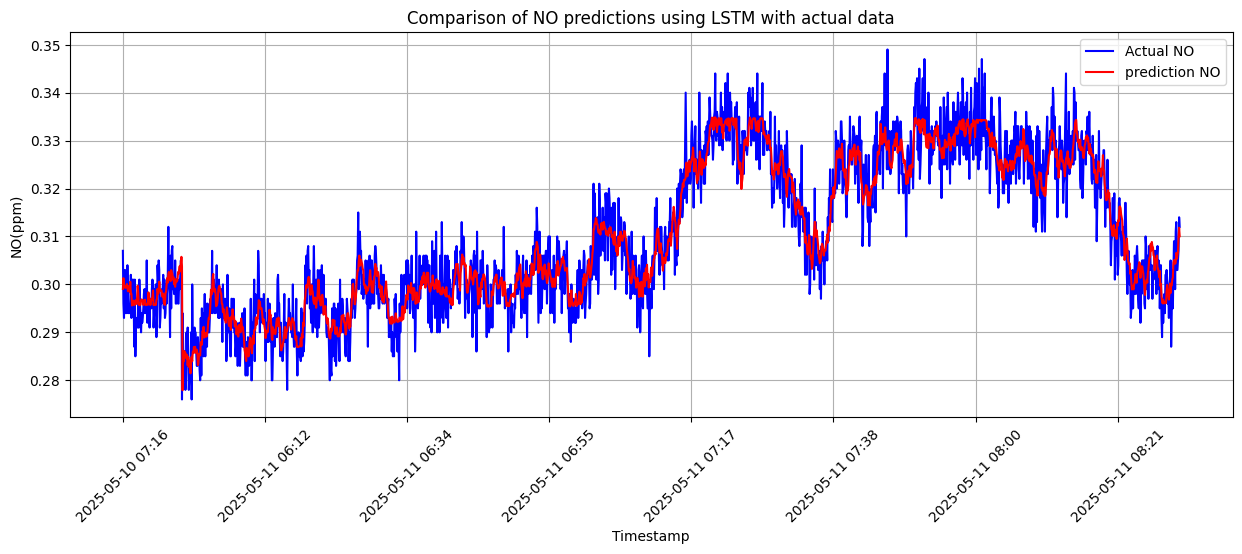


Layer 0 - lstm_5
  Bobot ke-0 shape: (4, 256)
  Bobot ke-1 shape: (64, 256)
  Bobot ke-2 shape: (256,)

Layer 1 - dense_5
  Bobot ke-0 shape: (64, 1)
  Bobot ke-1 shape: (1,)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load data ---
df = pd.read_excel("dataseth.xlsx")
df.dropna(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

# --- Fitur dan target ---
features = ['temperature', 'humidity', 'distance', 'speed']
target = 'no'   # target sekarang NO

# Ambil hanya data 7 hari
data_7hari = df[df['date'] <= pd.to_datetime("2025-05-11").date()]

X = data_7hari[features].values
y = data_7hari[target].values.reshape(-1, 1)

# --- Normalisasi ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# --- Sliding window ---
sequence_length = 24  # 24 jam
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# --- Split train/test 80:20 ---
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

# --- Bangun model LSTM ---
model = Sequential()
model.add(LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- Training ---
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=16, verbose=1)

# --- Evaluasi ---
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Balik ke skala asli
y_train_true = scaler_y.inverse_transform(y_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred)
y_test_true = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

# Hitung metrik
print("\nEvaluasi Training Data:")
print(f"R² Score : {r2_score(y_train_true, y_train_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_train_true, y_train_pred):.4f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_train_true, y_train_pred)):.4f}")

print("\nEvaluasi Test Data:")
print(f"R² Score : {r2_score(y_test_true, y_test_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_test_true, y_test_pred):.4f}")
print(f"MSE     : {np.sqrt(mean_squared_error(y_test_true, y_test_pred)):.4f}")

# --- Ambil timestamp yang sejajar dengan y_seq ---
timestamps_seq = data_7hari['timestamp'].iloc[sequence_length:].reset_index(drop=True)

# Split timestamp sama dengan y_seq
timestamps_train = timestamps_seq[:split_index]
timestamps_test = timestamps_seq[split_index:]

plt.figure(figsize=(15,5))

# Buat index numerik sesuai panjang data test
indices = np.arange(len(timestamps_test))

# Plot pakai index
plt.plot(indices, y_test_true, label="Actual NO", color='blue')
plt.plot(indices, y_test_pred, label="prediction NO", color='red')

# xticks per 250 data, label pakai timestamp asli
step = 250
plt.xticks(
    ticks=indices[::step],
    labels=timestamps_test.iloc[::step].dt.strftime('%Y-%m-%d %H:%M'),
    rotation=45
)

plt.xlabel("Timestamp")
plt.ylabel("NO(ppm)")
plt.title("Comparison of NO predictions using LSTM with actual data")
plt.legend()
plt.grid(True)
plt.show()

# --- Ambil bobot (weight & bias) dari model ---
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"\nLayer {i} - {layer.name}")
    for j, w in enumerate(weights):
        print(f"  Bobot ke-{j} shape: {w.shape}")
# Simpan semua weight & bias ke Excel
with pd.ExcelWriter("model_weights_bias_no.xlsx") as writer:
    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        for j, w in enumerate(weights):
            df = pd.DataFrame(w)  # ubah array jadi tabel
            sheet_name = f"{layer.name}_w{j}"
            df.to_excel(writer, sheet_name=sheet_name, index=False)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


465/465 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0187 - val_loss: 0.0021
Epoch 2/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 3/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 8/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 9/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 10/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 12/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/st

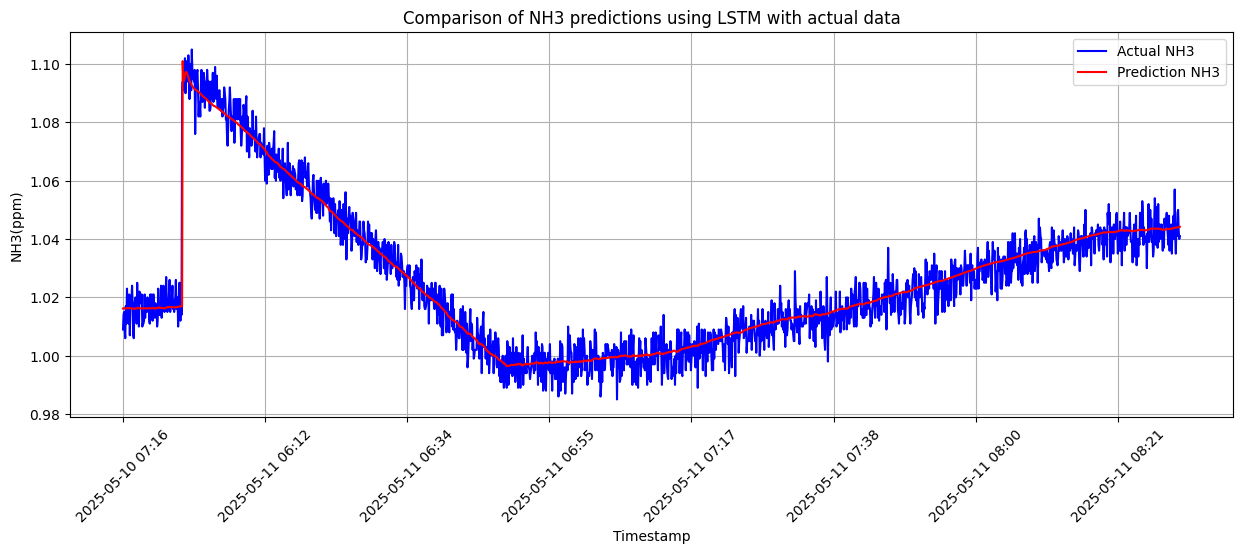


Layer 0 - lstm_6
  Bobot ke-0 shape: (4, 256)
  Bobot ke-1 shape: (64, 256)
  Bobot ke-2 shape: (256,)

Layer 1 - dense_6
  Bobot ke-0 shape: (64, 1)
  Bobot ke-1 shape: (1,)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load data ---
df = pd.read_excel("dataseth.xlsx")
df.dropna(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

# --- Fitur dan target ---
features = ['temperature', 'humidity', 'distance', 'speed']
target = 'nh3'   # target sekarang NH3

# Ambil hanya data 7 hari
data_7hari = df[df['date'] <= pd.to_datetime("2025-05-11").date()]

X = data_7hari[features].values
y = data_7hari[target].values.reshape(-1, 1)

# --- Normalisasi ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# --- Sliding window (24 jam) ---
sequence_length = 24
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# --- Split train/test 80:20 ---
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

# --- Bangun model LSTM ---
model = Sequential()
model.add(LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- Training ---
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=16, verbose=1)

# --- Evaluasi ---
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Balik ke skala asli
y_train_true = scaler_y.inverse_transform(y_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred)
y_test_true = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

# Hitung metrik
print("\nEvaluasi Training Data:")
print(f"R² Score : {r2_score(y_train_true, y_train_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_train_true, y_train_pred):.4f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_train_true, y_train_pred)):.4f}")

print("\nEvaluasi Test Data:")
print(f"R² Score : {r2_score(y_test_true, y_test_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_test_true, y_test_pred):.4f}")
print(f"MSE     : {np.sqrt(mean_squared_error(y_test_true, y_test_pred)):.4f}")

# --- Ambil timestamp yang sejajar dengan y_seq ---
timestamps_seq = data_7hari['timestamp'].iloc[sequence_length:].reset_index(drop=True)

# Split timestamp sama dengan y_seq
timestamps_train = timestamps_seq[:split_index]
timestamps_test = timestamps_seq[split_index:]

#
plt.figure(figsize=(15,5))

# Buat index numerik sesuai panjang data test
indices = np.arange(len(timestamps_test))

# Plot pakai index
plt.plot(indices, y_test_true, label="Actual NH3", color='blue')
plt.plot(indices, y_test_pred, label="Prediction NH3", color='red')

# xticks per 250 data, label pakai timestamp asli
step = 250
plt.xticks(
    ticks=indices[::step],
    labels=timestamps_test.iloc[::step].dt.strftime('%Y-%m-%d %H:%M'),
    rotation=45
)

plt.xlabel("Timestamp")
plt.ylabel("NH3(ppm)")
plt.title("Comparison of NH3 predictions using LSTM with actual data")
plt.legend()
plt.grid(True)
plt.show()

# --- Ambil bobot (weight & bias) dari model ---
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"\nLayer {i} - {layer.name}")
    for j, w in enumerate(weights):
        print(f"  Bobot ke-{j} shape: {w.shape}")
# Simpan semua weight & bias ke Excel
with pd.ExcelWriter("model_weights_bias_nh3.xlsx") as writer:
    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        for j, w in enumerate(weights):
            df = pd.DataFrame(w)  # ubah array jadi tabel
            sheet_name = f"{layer.name}_w{j}"
            df.to_excel(writer, sheet_name=sheet_name, index=False)



Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


465/465 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0133 - val_loss: 0.0018
Epoch 2/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 3/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 11/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 12/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/ste

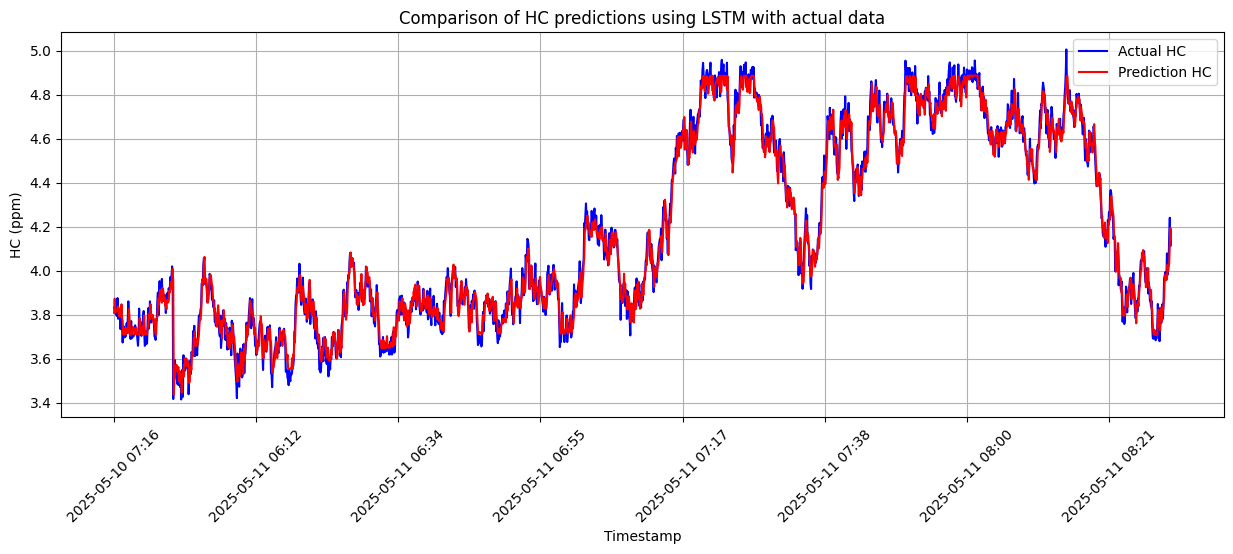


Layer 0 - lstm_7
  Bobot ke-0 shape: (4, 256)
  Bobot ke-1 shape: (64, 256)
  Bobot ke-2 shape: (256,)

Layer 1 - dense_7
  Bobot ke-0 shape: (64, 1)
  Bobot ke-1 shape: (1,)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load data ---
df = pd.read_excel("dataseth.xlsx")
df.dropna(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

# --- Fitur dan target ---
features = ['temperature', 'humidity', 'distance', 'speed']
target = 'hc'   # target sekarang HC

# Ambil hanya data 7 hari
data_7hari = df[df['date'] <= pd.to_datetime("2025-05-11").date()]

X = data_7hari[features].values
y = data_7hari[target].values.reshape(-1, 1)

# --- Normalisasi ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# --- Sliding window (24 jam) ---
sequence_length = 24
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# --- Split train/test 80:20 ---
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

# --- Bangun model LSTM ---
model = Sequential()
model.add(LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- Training ---
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=16, verbose=1)

# --- Evaluasi ---
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Balik ke skala asli
y_train_true = scaler_y.inverse_transform(y_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred)
y_test_true = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

# Hitung metrik
print("\nEvaluasi Training Data:")
print(f"R² Score : {r2_score(y_train_true, y_train_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_train_true, y_train_pred):.4f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_train_true, y_train_pred)):.4f}")

print("\nEvaluasi Test Data:")
print(f"R² Score : {r2_score(y_test_true, y_test_pred):.4f}")
print(f"MAE      : {mean_absolute_error(y_test_true, y_test_pred):.4f}")
print(f"MSE     : {np.sqrt(mean_squared_error(y_test_true, y_test_pred)):.4f}")

# --- Ambil timestamp yang sejajar dengan y_seq ---
timestamps_seq = data_7hari['timestamp'].iloc[sequence_length:].reset_index(drop=True)

# Split timestamp sama dengan y_seq
timestamps_train = timestamps_seq[:split_index]
timestamps_test = timestamps_seq[split_index:]

plt.figure(figsize=(15,5))

# Buat index numerik sesuai panjang data test
indices = np.arange(len(timestamps_test))

# Plot pakai index
plt.plot(indices, y_test_true, label="Actual HC", color='blue')
plt.plot(indices, y_test_pred, label="Prediction HC", color='red')

# xticks per 250 data, label pakai timestamp asli
step = 250
plt.xticks(
    ticks=indices[::step],
    labels=timestamps_test.iloc[::step].dt.strftime('%Y-%m-%d %H:%M'),
    rotation=45
)

plt.xlabel("Timestamp")
plt.ylabel("HC (ppm)")
plt.title("Comparison of HC predictions using LSTM with actual data")
plt.legend()
plt.grid(True)
plt.show()

# --- Ambil bobot (weight & bias) dari model ---
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"\nLayer {i} - {layer.name}")
    for j, w in enumerate(weights):
        print(f"  Bobot ke-{j} shape: {w.shape}")
# Simpan semua weight & bias ke Excel
with pd.ExcelWriter("model_weights_bias_hc.xlsx") as writer:
    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        for j, w in enumerate(weights):
            df = pd.DataFrame(w)  # ubah array jadi tabel
            sheet_name = f"{layer.name}_w{j}"
            df.to_excel(writer, sheet_name=sheet_name, index=False)



```pseudocode
# Import necessary libraries
IMPORT pandas AS pd
IMPORT numpy AS np
IMPORT matplotlib.pyplot AS plt
IMPORT timedelta FROM datetime
IMPORT MinMaxScaler FROM sklearn.preprocessing
IMPORT Sequential FROM tensorflow.keras.models
IMPORT LSTM, Dense FROM tensorflow.keras.layers

# Load and prepare data
LOAD data FROM "dataseth.xlsx" INTO dataframe df
DROP rows with missing values in df
CONVERT 'timestamp' column to datetime objects
EXTRACT 'date' and 'hour' components from 'timestamp'

# Define features and target variables
SET features TO ['temperature', 'humidity', 'distance', 'speed']
SET target TO 'pm'

# Split data into training set (7 days)
FILTER df to include dates up to "2025-05-11" and store in train_df
EXTRACT feature values from train_df INTO array X
EXTRACT target values from train_df INTO array y

# Normalize features and target
CREATE MinMaxScaler scaler_X for X
CREATE MinMaxScaler scaler_y for y
FIT and TRANSFORM X using scaler_X, store in X_scaled
FIT and TRANSFORM y using scaler_y, store in y_scaled

# Create dataset with sequences (24 hours sequence for 1 hour prediction)
SET sequence_length TO 24
INITIALIZE empty lists X_seq and y_seq
ITERATE from 0 to length of X_scaled minus sequence_length:
  APPEND sequence of X_scaled of length sequence_length starting from current index to X_seq
  APPEND value of y_scaled at current index + sequence_length to y_seq
CONVERT X_seq and y_seq to numpy arrays

# Build LSTM model
CREATE a Sequential model
ADD an LSTM layer with 64 units, input shape based on X_seq
ADD a Dense layer with 1 unit
COMPILE the model with 'adam' optimizer and 'mse' loss

# Train the model
FIT the model using X_seq and y_seq for 50 epochs with batch size 16

# Create data for 23 days future prediction
SET start_date TO "2025-05-12"
SET n_days TO 23
INITIALIZE empty dataframe future_data

GET unique dates from original df into source_dates

ITERATE from 0 to n_days-1:
  CALCULATE reference date from source_dates using modulo operator
  FILTER df for ref_date and store in ref_data
  GET unique hours from ref_data
  FILTER ref_data for those unique hours
  CALCULATE new_date by adding i days to start_date
  CALCULATE time difference (delta) between new_date and ref_date
  CREATE a copy of ref_data as new_data
  ADD delta to the timestamp in new_data
  EXTRACT new date and hour from updated timestamp in new_data
  CONCATENATE new_data to future_data

# Predict PM on future data
EXTRACT feature values from future_data into X_future
TRANSFORM X_future using scaler_X into X_future_scaled

# Shape input sequence for prediction
INITIALIZE empty list predicted_pm
GET the last sequence_length values from X_scaled into window

ITERATE from 0 to length of X_future_scaled - 1:
  APPEND the current value from X_future_scaled to window
  RESHAPE the last sequence_length values of window into input_seq for prediction
  PREDICT y_pred_scaled using the model and input_seq
  INVERSE TRANSFORM y_pred_scaled using scaler_y into y_pred
  APPEND the first element of y_pred to predicted_pm

# Store results
ADD predicted_pm as a new column 'pm_predicted' in future_data

# Calculate and print total predicted PM
CALCULATE the sum of 'pm_predicted' in future_data
PRINT the total predicted PM

# Plot results
CREATE a figure and axes
PLOT actual PM from train_df vs timestamp
PLOT predicted PM from future_data vs timestamp
SET x-label, y-label, and title
ADD legend and grid
ADJUST layout
SHOW the plot

# Evaluate on training data
PREDICT y_train_pred_scaled using the model on X_seq
INVERSE TRANSFORM y_train_pred_scaled using scaler_y into y_train_pred
INVERSE TRANSFORM y_seq using scaler_y into y_train_actual

# Calculate and print evaluation metrics
CALCULATE R² score between y_train_actual and y_train_pred
CALCULATE MSE between y_train_actual and y_train_pred
CALCULATE MAE between y_train_actual and y_train_pred
PRINT evaluation metrics (R², MSE, MAE)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Prediksi pada data pelatihan
y_train_pred_scaled = model.predict(X_seq)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_seq)

# Hitung metrik
r2 = r2_score(y_train_actual, y_train_pred)
mse = mean_squared_error(y_train_actual, y_train_pred)
mae = mean_absolute_error(y_train_actual, y_train_pred)

print(f"\nEvaluasi pada data pelatihan:")
print(f"R² Score: {r2:.4f}")
print(f"MSE     : {mse:.4f}")
print(f"MAE     : {mae:.4f}")


291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Evaluasi pada data pelatihan:
R² Score: 0.9790
MSE     : 0.0032
MAE     : 0.0425
